# Getting Start with GAN

### Goal
In this notebook, we're going to create our first generative adversarial network (GAN). we will build and train a GAN that can generate hand-written images of digits (0-9) from scratch. In this notebook we are use Torch library. We so ready in journey of adding GAN tool in your collection. 

### Learning Objectives
1.   Build the generator and discriminator components of a GAN from scratch.
2.   Create generator and discriminator loss functions.
3.   Train your GAN and visualize the generated images.


## Getting Started
we will begin by importing some useful packages and the dataset you will use to build and train our GAN. we are also provided with a visualizer function to help you investigate the images your GAN will create.


In [21]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### MNIST Dataset
The training images our discriminator will be using is from a dataset called [MNIST](http://yann.lecun.com/exdb/mnist/). It contains 60,000 images of handwritten digits, from 0 to 9, like these:


## Generator
The first step is to build the generator component.

We will start by creating a function to make a single layer/block for the generator's neural network. Each block should include a [linear transformation] to map to another shape, a [batch normalization] for stabilization, and finally a non-linear activation function (we use a [ReLU here].

In [3]:
# GRADED FUNCTION: get_generator_block
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )

Now you can build the generator class. It will take 3 values:

*   The noise vector dimension
*   The image dimension
*   The initial hidden dimension

Using these values, the generator will build a neural network with 5 layers/blocks. Beginning with the noise vector, the generator will apply non-linear transformations via the block function until the tensor is mapped to the size of the image to be outputted (the same size as the real images from MNIST). You will need to fill in the code for final layer since it is different than the others. The final layer does not need a normalization or activation function, but does need to be scaled with a [sigmoid function](https://pytorch.org/docs/master/generated/torch.nn.Sigmoid.html). 

In [4]:
# GRADED FUNCTION: Generator
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

## Noise
To be able to use your generator, you will need to be able to create noise vectors. The noise vector z has the important role of making sure the images generated from the same class don't all look the same -- think of it as a random seed. You will generate it randomly using PyTorch by sampling random numbers from the normal distribution. Since multiple images will be processed per pass, you will generate all the noise vectors at once.




In [5]:
# GRADED FUNCTION: get_noise
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples,z_dim, device = device)

## Discriminator
The second component that you need to construct is the discriminator. As with the generator component, you will start by creating a function that builds a neural network block for the discriminator.




In [6]:
# GRADED FUNCTION: get_discriminator_block
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2
    '''
    return nn.Sequential(
        nn.Linear(input_dim,output_dim),
        nn.LeakyReLU(0.2)
    )

Now you can use these blocks to make a discriminator! The discriminator class holds 2 values:

*   The image dimension
*   The hidden dimension

The discriminator will build a neural network with 4 layers. It will start with the image tensor and transform it until it returns a single number (1-dimension tensor) output. This output classifies whether an image is fake or real. Note that you do not need a sigmoid after the output layer since it is included in the loss function. Finally, to use your discrimator's neural network you are given a forward pass function that takes in an image tensor to be classified.


In [7]:
# GRADED FUNCTION: Discriminator
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim,1),
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
 
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

## Training
Now you can put it all together!
First, you will set your parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type, here using a GPU (which runs CUDA), not CPU

Next, you will load the MNIST dataset as tensors using a dataloader.


In [13]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
im_dim = 784
# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=False, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

device = 'cpu'

Now, you can initialize your generator, discriminator, and optimizers. Note that each optimizer only takes the parameters of one particular model, since we want each optimizer to optimize only one of the models.

In [14]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Before you train your GAN, you will need to create functions to calculate the discriminator's loss and the generator's loss. This is how the discriminator and generator will know how they are doing and improve themselves. Since the generator is needed when calculating the discriminator's loss, you will need to call .detach() on the generator result to ensure that only the discriminator is updated!

Remember that you have already defined a loss function earlier (`criterion`) and you are encouraged to use `torch.ones_like` and `torch.zeros_like` instead of `torch.ones` or `torch.zeros`. If you use `torch.ones` or `torch.zeros`, you'll need to pass `device=device` to them.

In [15]:
# GRADED FUNCTION: get_disc_loss
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
   
    noise = get_noise(num_images, z_dim, device)
    
    noise = get_noise(num_images, z_dim, device = device)
    generated_images = gen(noise)
    fake_preds = disc(generated_images.detach())
    fake_loss = criterion(fake_preds, torch.zeros_like(fake_preds))
    
    real_preds = disc(real)
    real_loss = criterion(real_preds, torch.ones_like(real_preds))
    disc_loss = (fake_loss + real_loss)/2
    return disc_loss

In [16]:
# GRADED FUNCTION: get_gen_loss
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    noise = get_noise(num_images, z_dim, device)
    generated_images = gen(noise)
    fake_preds = disc(generated_images)
    fake_loss = criterion(fake_preds, torch.ones_like(fake_preds))
    gen_loss = fake_loss
    return gen_loss

Finally, you can put everything together! For each epoch, you will process the entire dataset in batches. For every batch, you will need to update the discriminator and generator using their loss. Batches are sets of images that will be predicted on before the loss functions are calculated (instead of calculating the loss function after each image). Note that you may see a loss to be greater than 1, this is okay since binary cross entropy loss can be any positive number for a sufficiently confident wrong guess. 
​
It’s also often the case that the discriminator will outperform the generator, especially at the start, because its job is easier. It's important that neither one gets too good (that is, near-perfect accuracy), which would cause the entire model to stop learning. Balancing the two models is actually remarkably hard to do in a standard GAN and something you will see more of in later lectures and assignments.
​

Epoch 1, step 500: Generator loss: 1.3668050762414945, discriminator loss: 0.4419477572441102


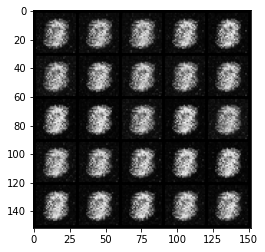

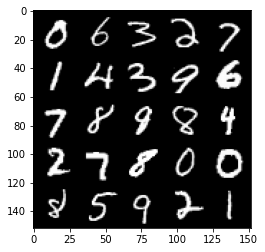

Epoch 2, step 1000: Generator loss: 1.6834846069812768, discriminator loss: 0.30842947417497657


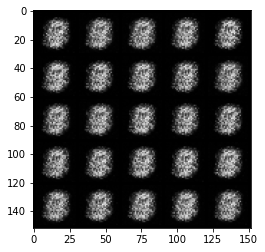

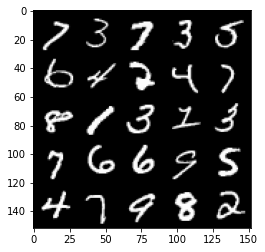

Epoch 3, step 1500: Generator loss: 1.9825192875862128, discriminator loss: 0.17747872105240833


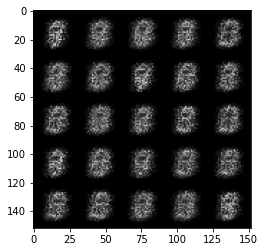

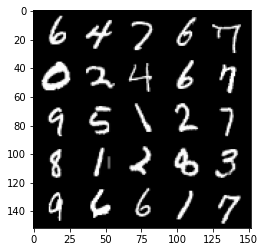

Epoch 4, step 2000: Generator loss: 1.6956915876865382, discriminator loss: 0.2195999172031877


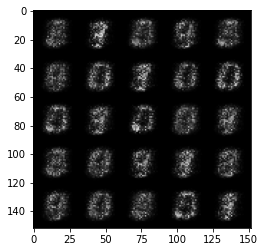

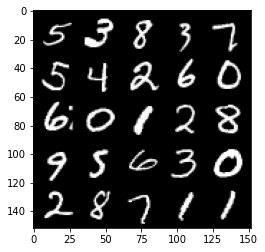

Epoch 5, step 2500: Generator loss: 1.5727269711494454, discriminator loss: 0.23614322751760458


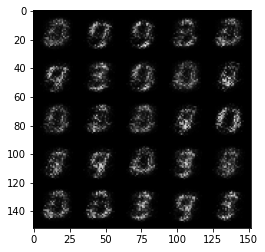

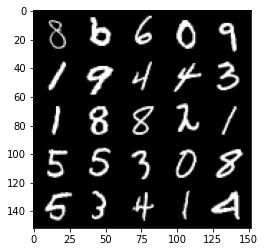

Epoch 6, step 3000: Generator loss: 1.7719962456226352, discriminator loss: 0.1988787132799626


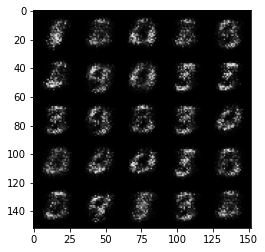

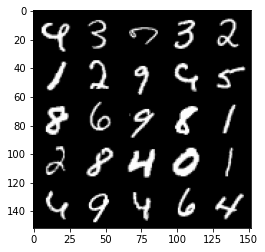

Epoch 7, step 3500: Generator loss: 2.1112925286293027, discriminator loss: 0.16786705350875847


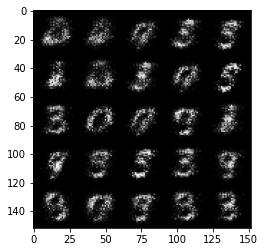

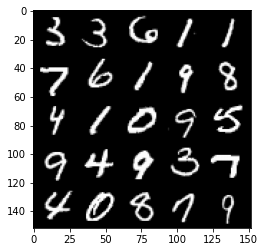

Epoch 8, step 4000: Generator loss: 2.4910220150947575, discriminator loss: 0.14245137952268108


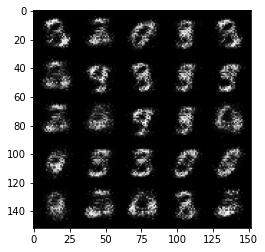

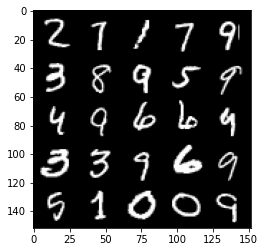

Epoch 9, step 4500: Generator loss: 2.8699578709602367, discriminator loss: 0.10645898526161895


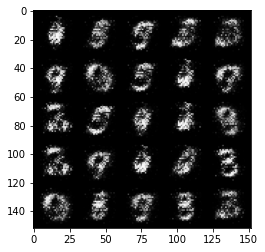

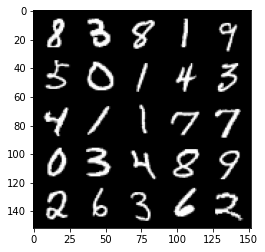

Epoch 10, step 5000: Generator loss: 3.3064919362068195, discriminator loss: 0.08139986013621098


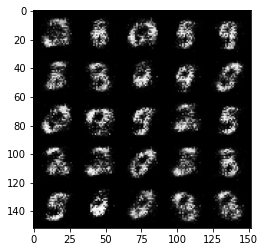

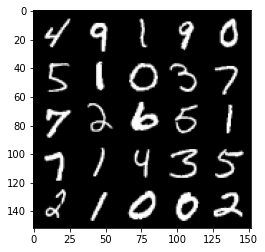

Epoch 11, step 5500: Generator loss: 3.4826476755142206, discriminator loss: 0.06747853071987628


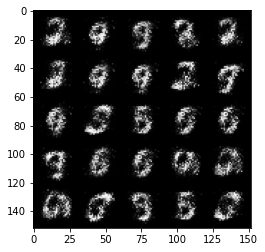

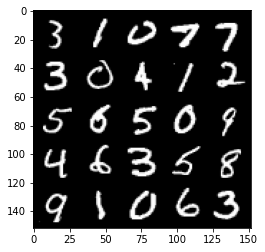

Epoch 12, step 6000: Generator loss: 3.679556049823762, discriminator loss: 0.06158029606193312


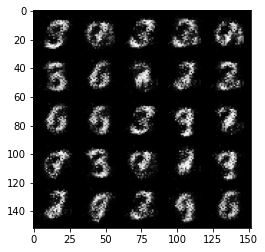

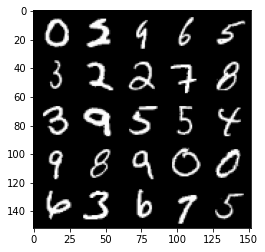

Epoch 13, step 6500: Generator loss: 3.7243907041549664, discriminator loss: 0.06659162186831238


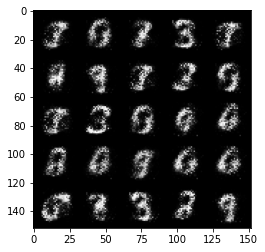

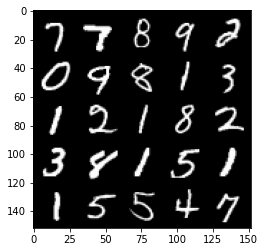

Epoch 14, step 7000: Generator loss: 4.060434439659116, discriminator loss: 0.07031453566998246


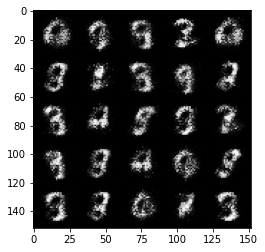

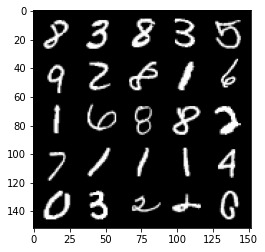

Epoch 15, step 7500: Generator loss: 3.7928944268226648, discriminator loss: 0.075620622113347


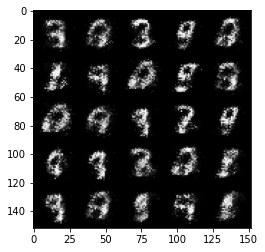

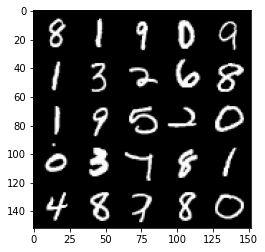

Epoch 17, step 8000: Generator loss: 3.846006050586701, discriminator loss: 0.07290124724060298


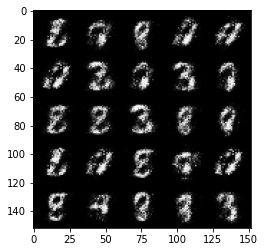

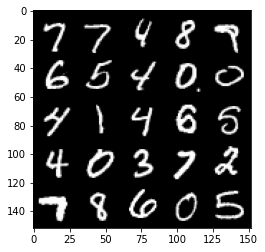

Epoch 18, step 8500: Generator loss: 3.9106377887725836, discriminator loss: 0.07944237858057024


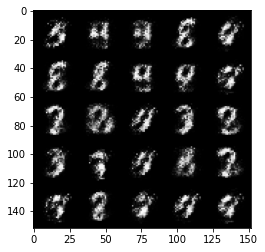

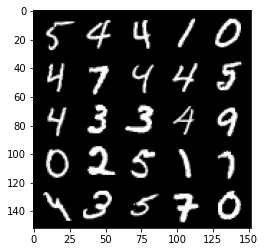

Epoch 19, step 9000: Generator loss: 3.7491179728507986, discriminator loss: 0.08050186424702406


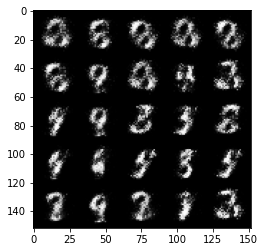

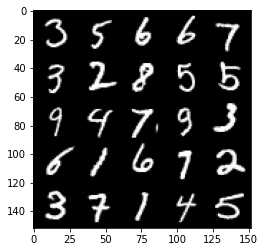

Epoch 20, step 9500: Generator loss: 3.726868203639986, discriminator loss: 0.06744223723560577


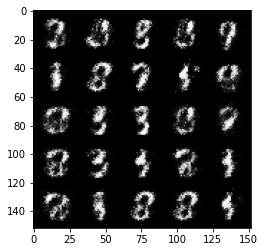

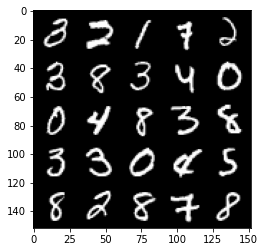

Epoch 21, step 10000: Generator loss: 3.8276872363090515, discriminator loss: 0.06465767294913533


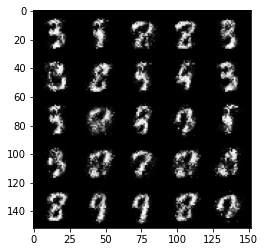

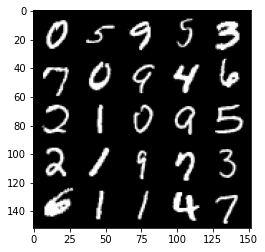

Epoch 22, step 10500: Generator loss: 4.065480517864227, discriminator loss: 0.06275845077261323


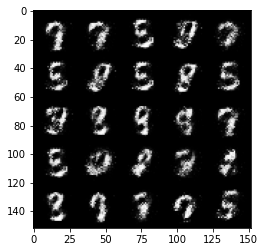

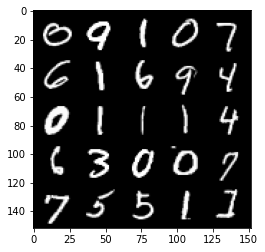

Epoch 23, step 11000: Generator loss: 3.9815341906547563, discriminator loss: 0.06661613279953602


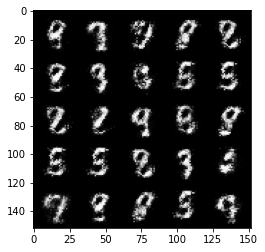

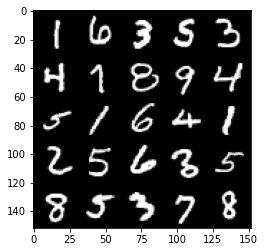

Epoch 24, step 11500: Generator loss: 3.9118744449615472, discriminator loss: 0.07768425206094987


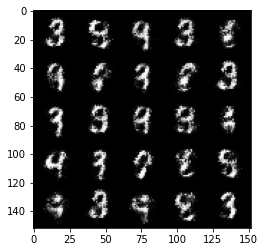

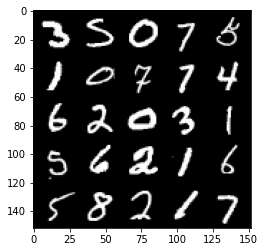

Epoch 25, step 12000: Generator loss: 3.858088714599608, discriminator loss: 0.08624947777390476


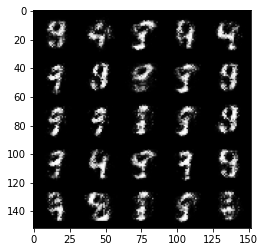

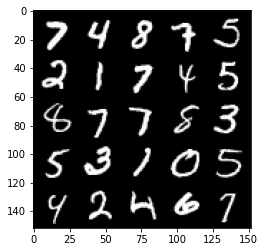

Epoch 26, step 12500: Generator loss: 3.9370352792739807, discriminator loss: 0.0787732082754374


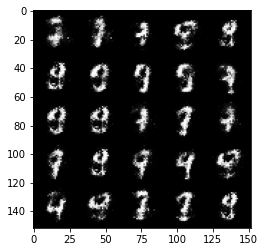

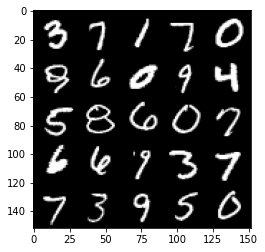

Epoch 27, step 13000: Generator loss: 3.9978314876556404, discriminator loss: 0.09145812182128432


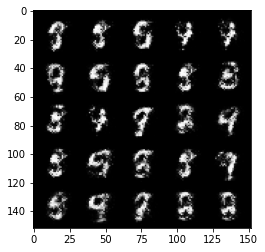

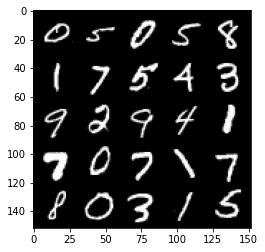

Epoch 28, step 13500: Generator loss: 4.0023185095787035, discriminator loss: 0.0919583217352628


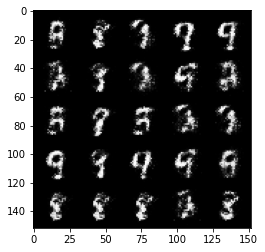

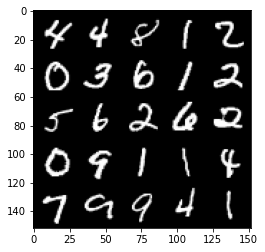

Epoch 29, step 14000: Generator loss: 3.955365999221803, discriminator loss: 0.106184797115624


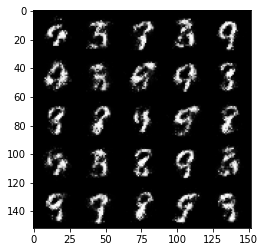

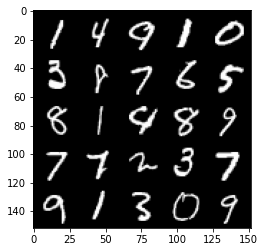

Epoch 30, step 14500: Generator loss: 3.8045638723373414, discriminator loss: 0.10356161423027516


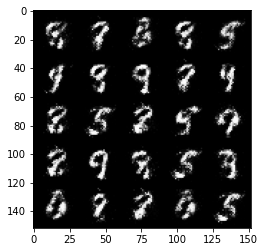

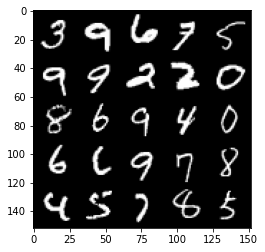

Epoch 31, step 15000: Generator loss: 3.7936119909286496, discriminator loss: 0.09893207493424423


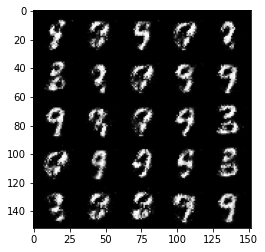

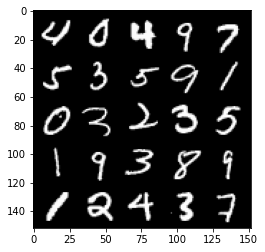

Epoch 33, step 15500: Generator loss: 3.7604904284477234, discriminator loss: 0.09769934757798905


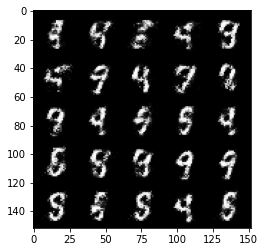

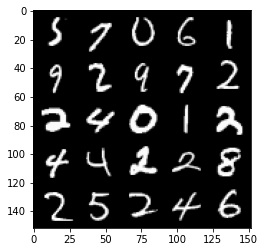

Epoch 34, step 16000: Generator loss: 3.7286298060417145, discriminator loss: 0.09574943307042119


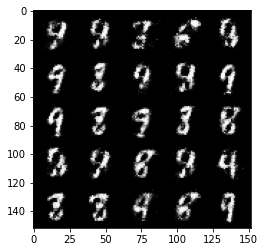

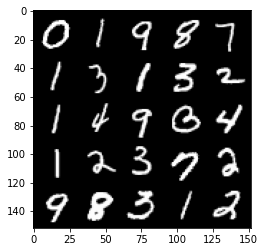

Epoch 35, step 16500: Generator loss: 3.7284205036163325, discriminator loss: 0.10185983585566281


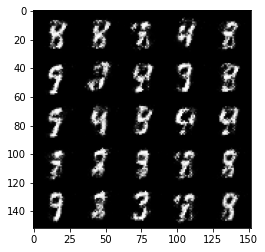

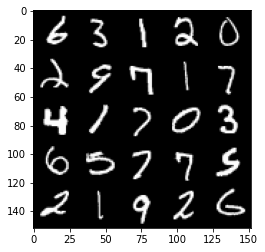

Epoch 36, step 17000: Generator loss: 3.620024671077731, discriminator loss: 0.12538929194211956


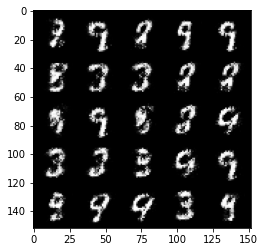

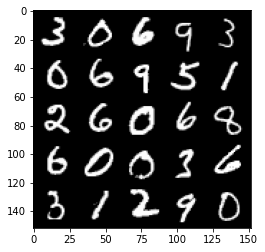

Epoch 37, step 17500: Generator loss: 3.6141156244277974, discriminator loss: 0.12505426026880737


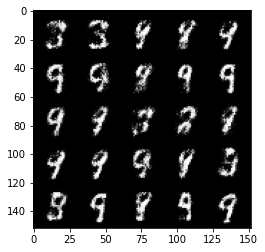

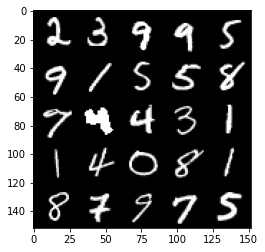

Epoch 38, step 18000: Generator loss: 3.604396352291107, discriminator loss: 0.1130489112064241


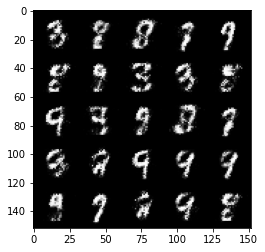

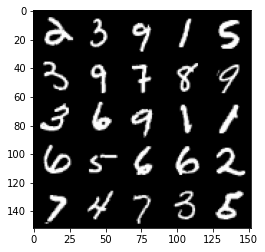

Epoch 39, step 18500: Generator loss: 3.605306715011596, discriminator loss: 0.10875875993072981


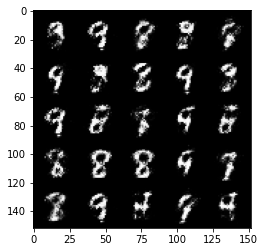

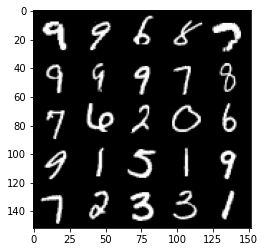

Epoch 40, step 19000: Generator loss: 3.6733144841194143, discriminator loss: 0.10383040770143276


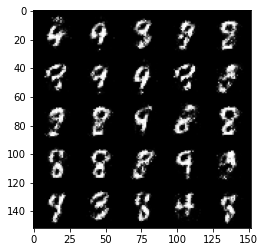

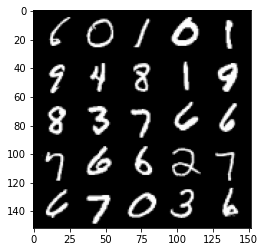

Epoch 41, step 19500: Generator loss: 3.7049445743560803, discriminator loss: 0.11284704689681531


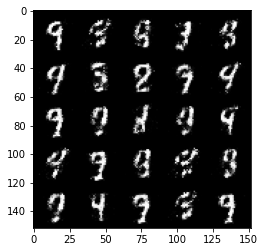

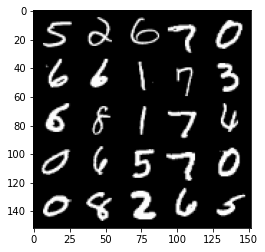

Epoch 42, step 20000: Generator loss: 3.520762934684752, discriminator loss: 0.1372111810445784


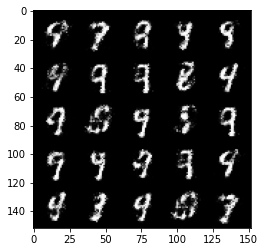

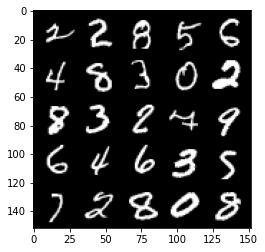

Epoch 43, step 20500: Generator loss: 3.32055963611603, discriminator loss: 0.14035480575263504


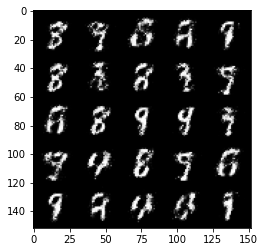

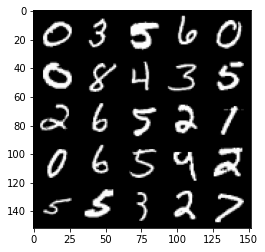

Epoch 44, step 21000: Generator loss: 3.550667055606844, discriminator loss: 0.12608956566452986


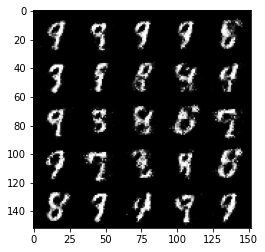

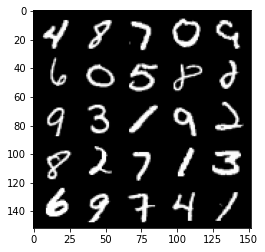

Epoch 45, step 21500: Generator loss: 3.3663998408317557, discriminator loss: 0.13678782114386545


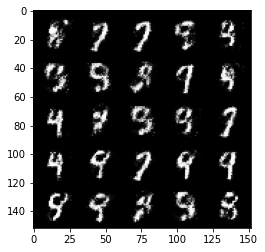

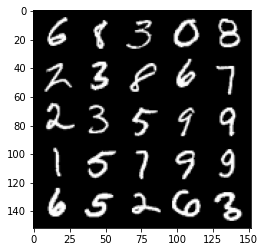

Epoch 46, step 22000: Generator loss: 3.254021752357483, discriminator loss: 0.15684478566050528


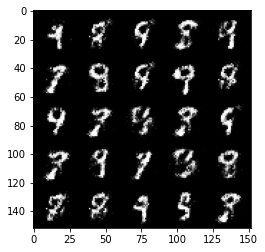

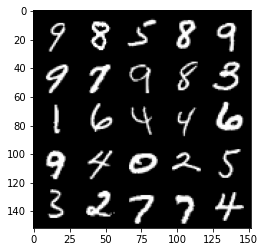

Epoch 47, step 22500: Generator loss: 3.235183522701264, discriminator loss: 0.15495650966465468


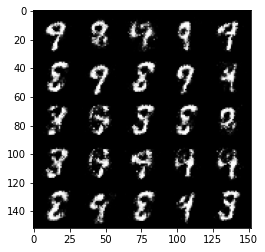

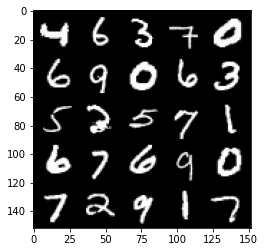

Epoch 49, step 23000: Generator loss: 3.1252723717689515, discriminator loss: 0.17026367108523838


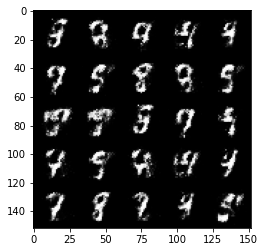

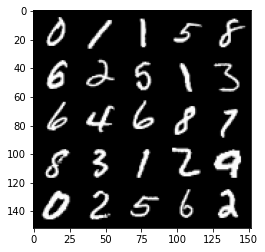

Epoch 50, step 23500: Generator loss: 3.218431554794312, discriminator loss: 0.16355166792869563


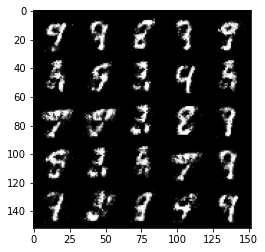

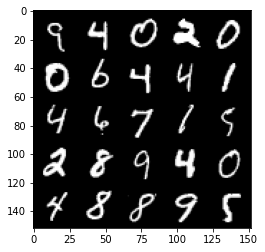

Epoch 51, step 24000: Generator loss: 3.1585272450447115, discriminator loss: 0.1676771997213365


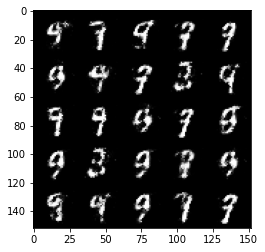

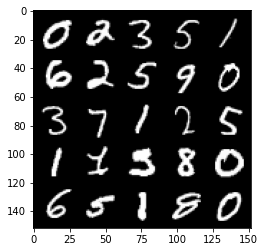

Epoch 52, step 24500: Generator loss: 3.051885740756989, discriminator loss: 0.16550187160074709


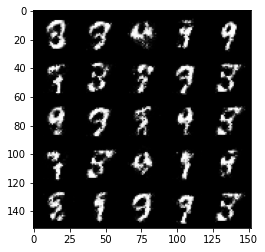

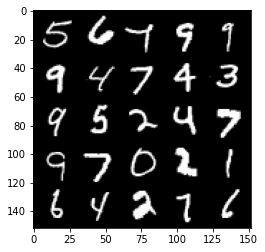

Epoch 53, step 25000: Generator loss: 2.875391042232515, discriminator loss: 0.1813882689625024


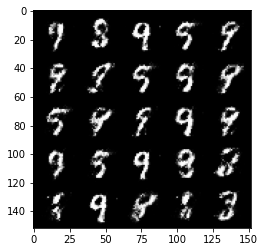

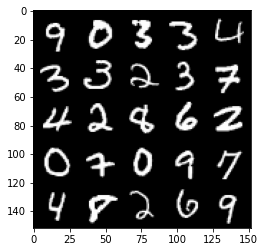

Epoch 54, step 25500: Generator loss: 3.1012950091362015, discriminator loss: 0.15724952948838464


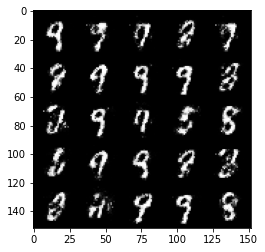

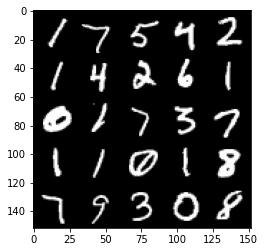

Epoch 55, step 26000: Generator loss: 3.0748668451309182, discriminator loss: 0.1769703241288663


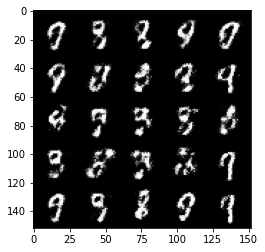

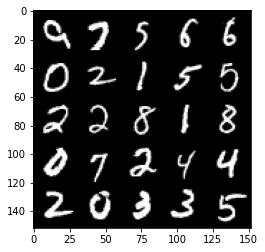

Epoch 56, step 26500: Generator loss: 2.92101472043991, discriminator loss: 0.1846077466011045


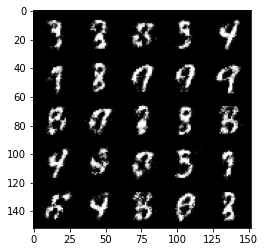

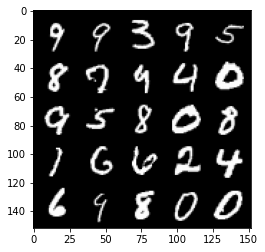

Epoch 57, step 27000: Generator loss: 3.0124272475242613, discriminator loss: 0.1895972256809471


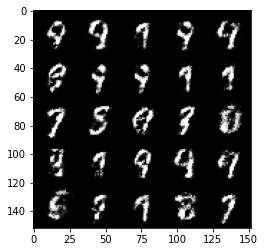

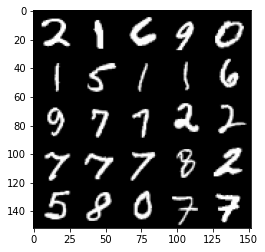

Epoch 58, step 27500: Generator loss: 2.778145750522613, discriminator loss: 0.1983003090620039


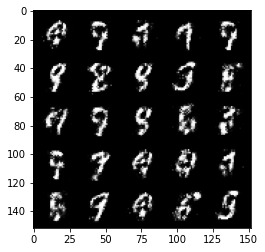

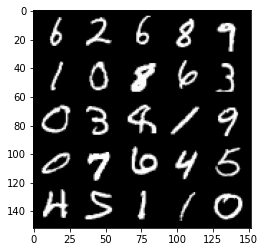

Epoch 59, step 28000: Generator loss: 2.8385865821838387, discriminator loss: 0.20298409141600113


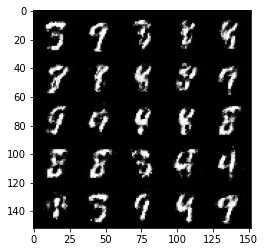

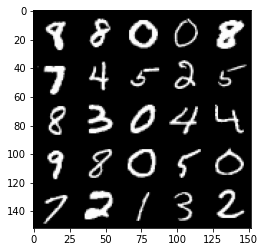

Epoch 60, step 28500: Generator loss: 2.9037192778587353, discriminator loss: 0.18291777068376544


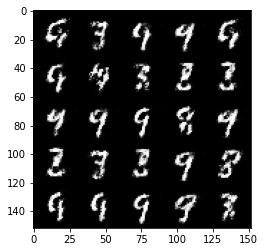

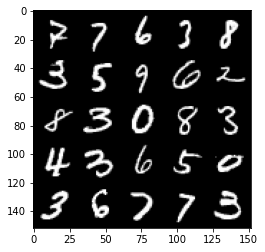

Epoch 61, step 29000: Generator loss: 2.7332398033142113, discriminator loss: 0.21765389245748515


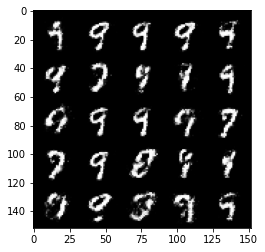

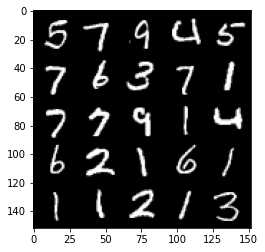

Epoch 62, step 29500: Generator loss: 2.6298939394950884, discriminator loss: 0.22030802971124633


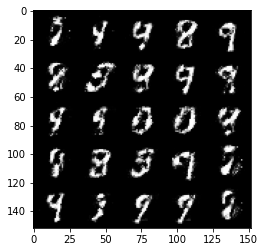

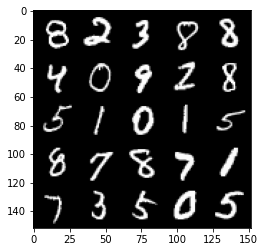

Epoch 63, step 30000: Generator loss: 2.5158450593948394, discriminator loss: 0.2442796985507012


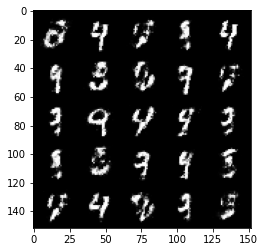

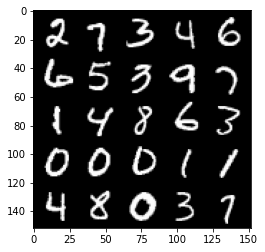

Epoch 65, step 30500: Generator loss: 2.5714971990585336, discriminator loss: 0.2418584348857402


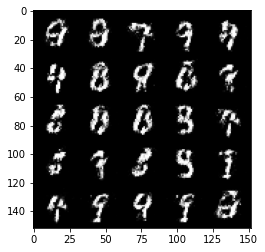

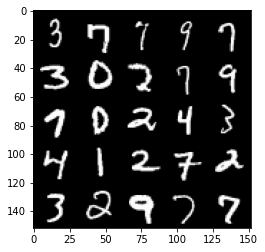

Epoch 66, step 31000: Generator loss: 2.610055529594421, discriminator loss: 0.22774803084135048


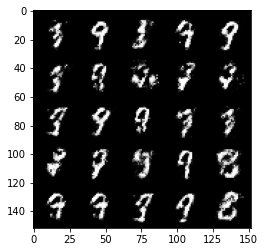

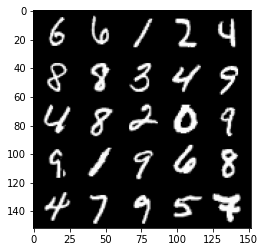

Epoch 67, step 31500: Generator loss: 2.5370246376991292, discriminator loss: 0.23895880308747292


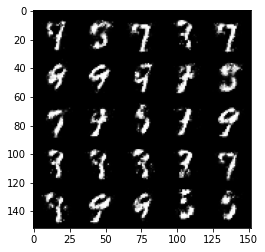

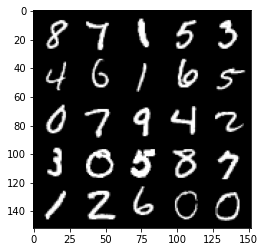

Epoch 68, step 32000: Generator loss: 2.528440353870393, discriminator loss: 0.2338040783703328


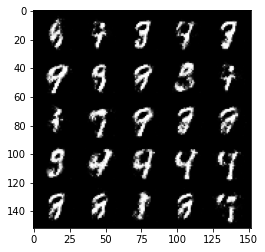

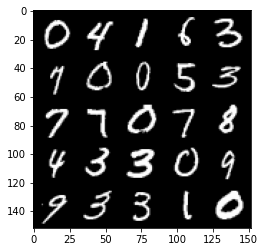

Epoch 69, step 32500: Generator loss: 2.5645105757713313, discriminator loss: 0.24669965937733632


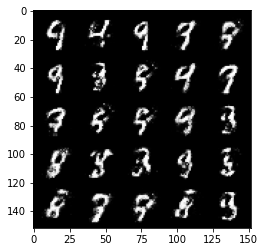

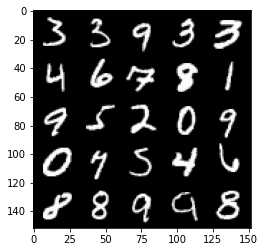

Epoch 70, step 33000: Generator loss: 2.4444548852443715, discriminator loss: 0.2438691485226154


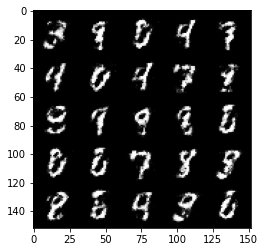

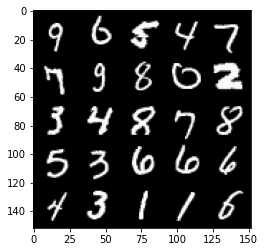

Epoch 71, step 33500: Generator loss: 2.5288666980266576, discriminator loss: 0.22619984099268928


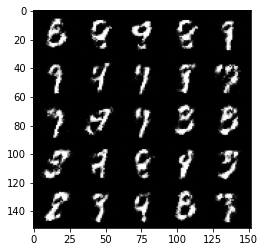

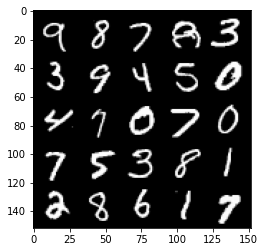

Epoch 72, step 34000: Generator loss: 2.502046175479889, discriminator loss: 0.2554007804393767


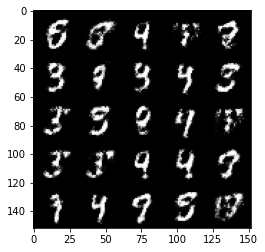

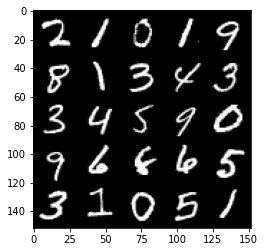

Epoch 73, step 34500: Generator loss: 2.4590577218532537, discriminator loss: 0.24110234540700906


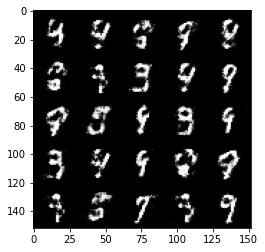

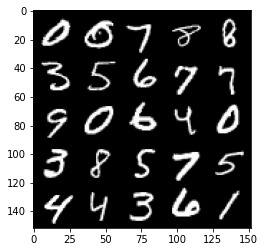

Epoch 74, step 35000: Generator loss: 2.4559988768100736, discriminator loss: 0.24820607390999777


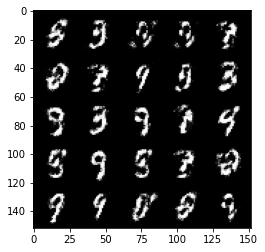

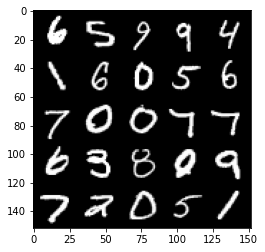

Epoch 75, step 35500: Generator loss: 2.4250327887535095, discriminator loss: 0.249607395529747


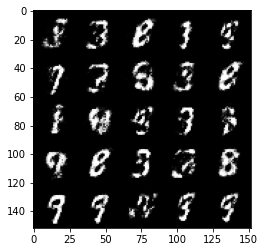

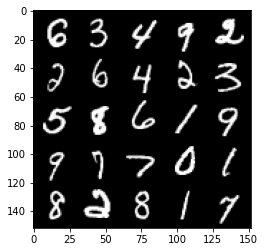

Epoch 76, step 36000: Generator loss: 2.35406930041313, discriminator loss: 0.262065358132124


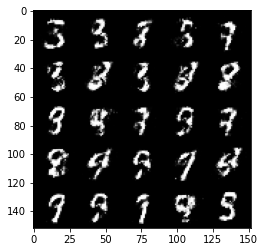

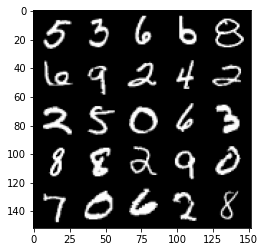

Epoch 77, step 36500: Generator loss: 2.5026666376590714, discriminator loss: 0.23342430615425083


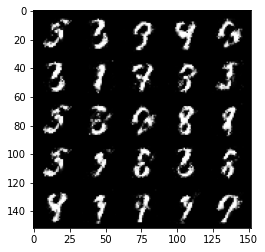

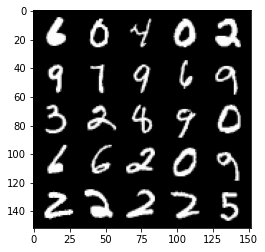

Epoch 78, step 37000: Generator loss: 2.474542831659318, discriminator loss: 0.2517643759846689


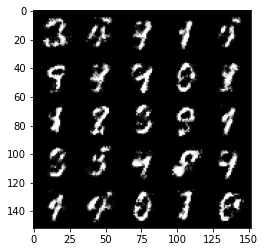

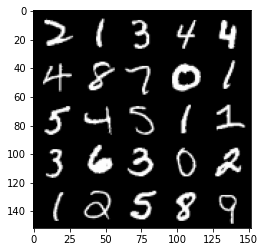

Epoch 79, step 37500: Generator loss: 2.407211975574492, discriminator loss: 0.2480270676910879


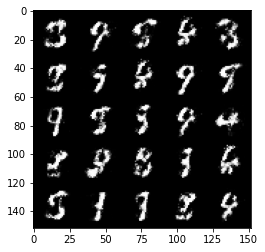

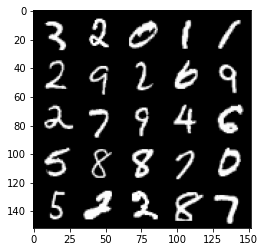

Epoch 81, step 38000: Generator loss: 2.4761590282917028, discriminator loss: 0.2339594044387341


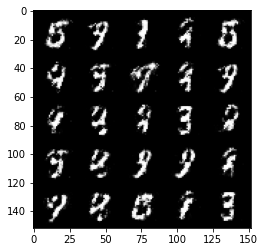

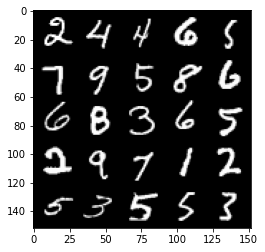

Epoch 82, step 38500: Generator loss: 2.547940845489505, discriminator loss: 0.23230919823050503


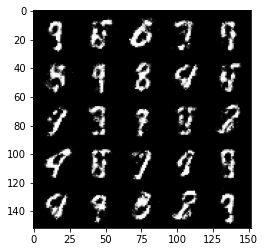

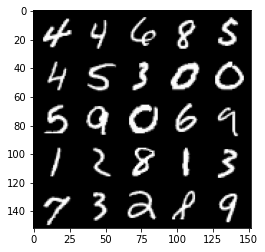

Epoch 83, step 39000: Generator loss: 2.3333815166950234, discriminator loss: 0.2609956308305261


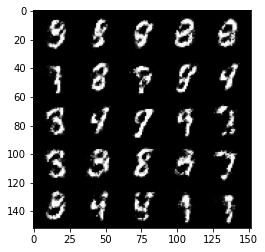

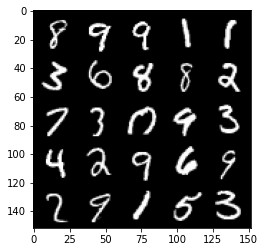

Epoch 84, step 39500: Generator loss: 2.4693035168647794, discriminator loss: 0.2347836325168609


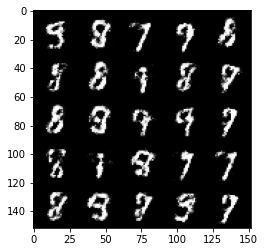

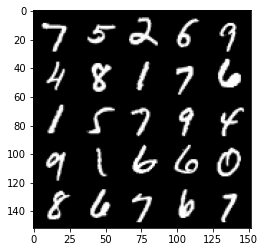

Epoch 85, step 40000: Generator loss: 2.3567527527809147, discriminator loss: 0.2610946880280969


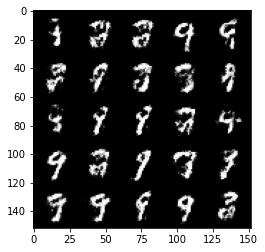

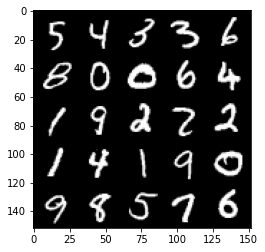

Epoch 86, step 40500: Generator loss: 2.2513429601192474, discriminator loss: 0.27822343188524246


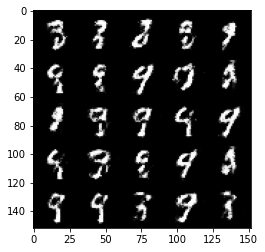

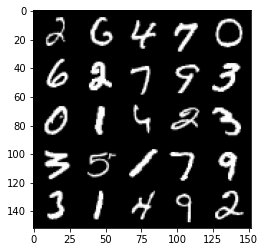

Epoch 87, step 41000: Generator loss: 2.287381464958191, discriminator loss: 0.26829039794206644


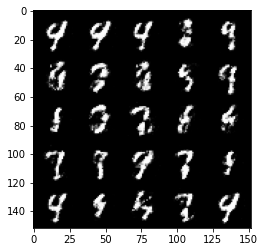

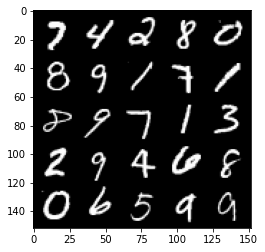

Epoch 88, step 41500: Generator loss: 2.3009611907005336, discriminator loss: 0.2569486606121062


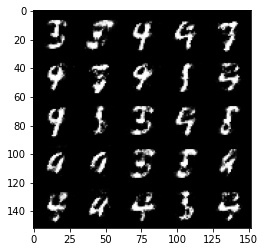

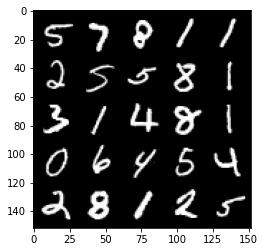

Epoch 89, step 42000: Generator loss: 2.407909998893738, discriminator loss: 0.2505326663553715


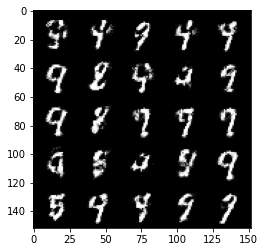

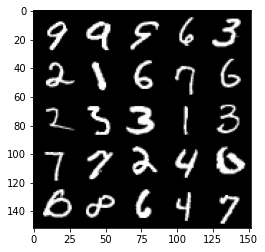

Epoch 90, step 42500: Generator loss: 2.221060668468476, discriminator loss: 0.27657099819183356


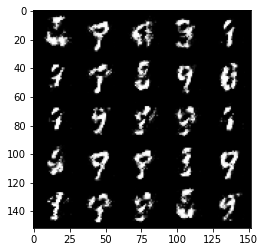

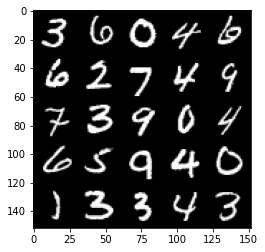

Epoch 91, step 43000: Generator loss: 2.2899317278862, discriminator loss: 0.26142024526


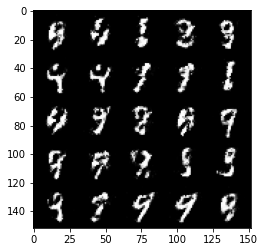

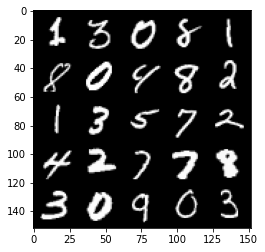

Epoch 92, step 43500: Generator loss: 2.253742290019987, discriminator loss: 0.2806000557541846


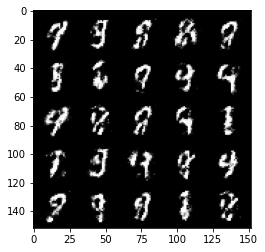

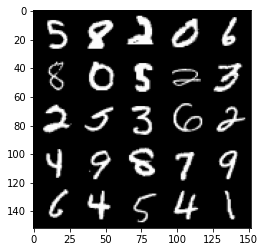

Epoch 93, step 44000: Generator loss: 2.2391552939415007, discriminator loss: 0.28253175342082953


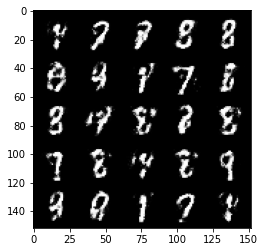

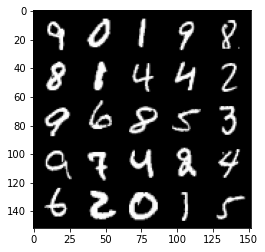

Epoch 94, step 44500: Generator loss: 2.057919722557067, discriminator loss: 0.3064159591794011


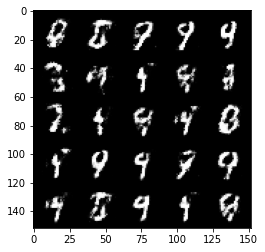

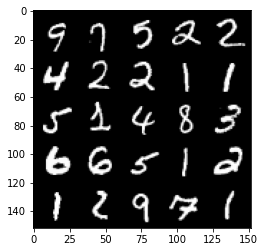

Epoch 95, step 45000: Generator loss: 1.9658926925659186, discriminator loss: 0.3334343479573728


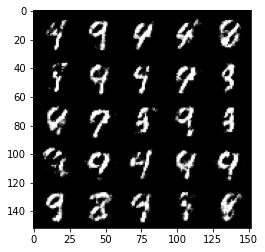

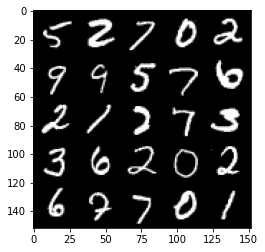

Epoch 97, step 45500: Generator loss: 2.0039138460159305, discriminator loss: 0.3221332328319547


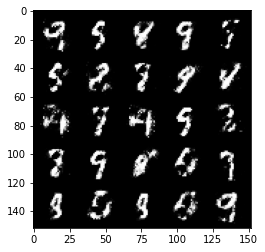

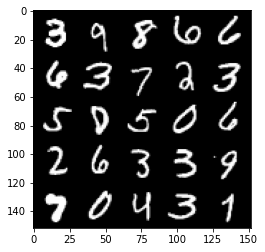

Epoch 98, step 46000: Generator loss: 2.0263471362590795, discriminator loss: 0.30094652619957923


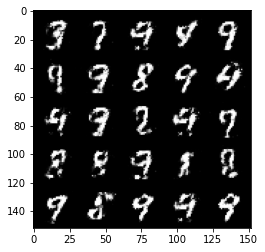

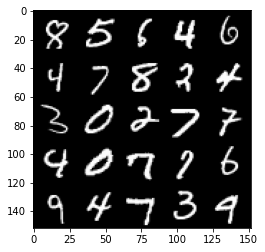

Epoch 99, step 46500: Generator loss: 2.081477224349979, discriminator loss: 0.3008733652532101


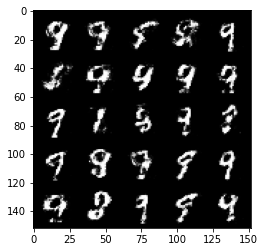

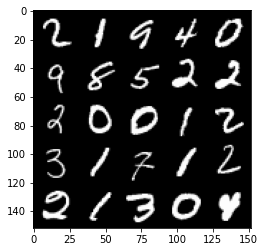

In [17]:
# GRADED FUNCTION: 

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_loss = False
error = False
for epoch in range(100):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        

        ### Update generator ###
        
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()

        

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


## Thanks for reading hope you learn something